<a href="https://colab.research.google.com/github/fred2167/Personal-Project/blob/master/custom_dataset_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from PIL import Image

'''
TODO:
- Add bounding box for multiple food classes in one image
- Transform bounding box coordinates alongside standard transforming 
'''

In [3]:
transformer = torchvision.transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                             ])
                                             
fp = r"C:\Users\Marcus\Desktop\datasets\UECFOOD100"
fred_fp = '/home/fred/datasets/dataset100/UECFOOD100/'
data = torchvision.datasets.ImageFolder(fp, transform=transformer)
loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)


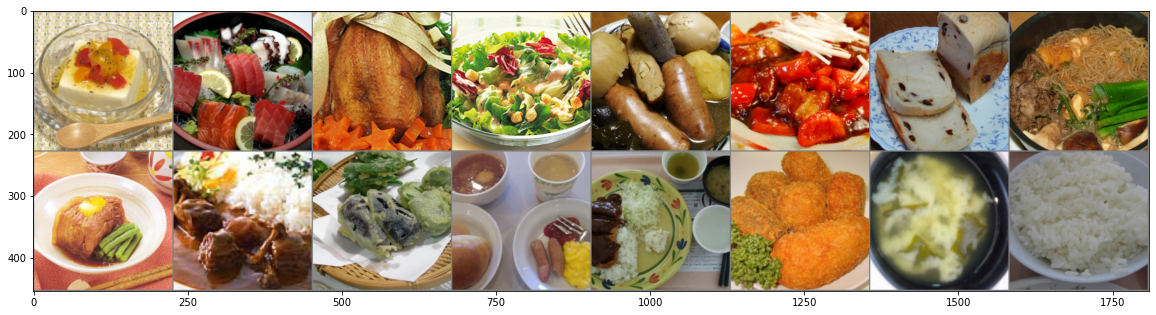

In [5]:
def imshow(img):
    img = img /2 +0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show

dataiter = iter(loader)
images, label = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [39]:
class UECFoodLabelsDataset(Dataset):
    """
    Food Dataset that contains 100 different food labels
    [1-100] : directory names correspond to food ID.
    [1-100]/*.jpg : food photo files (some photos are duplicated in two or more directories, since they includes two or more food items.)
    [1-100]/bb_info.txt: bounding box information for the photo files in each directory

    http://foodcam.mobi/dataset100.html
    """

    def __init__(self, root, transform=None):
        category_file = open(os.path.join(root, "category.txt"), "r")
        
        # map the folder names to the food name
        self.id_to_class = {}
        for line in category_file.readlines():
            food_id, name = line.split("\t", 2)
            if food_id.isdigit():
                self.id_to_class[food_id] = name.strip()

        # # map image_id to food name 
        self.image_id_to_foodname_dict = {}
        for food_id in self.id_to_class.keys():
            for image_id in os.listdir(os.path.join(root, str(food_id))):
                self.image_id_to_foodname_dict[image_id] = self.id_to_class[food_id]

        # make a master list of every image path
        self.image_path_list = []
        for food_id in self.id_to_class.keys():
            food_folder_fp = os.path.join(root, str(food_id))
            for image_file_name in os.listdir(food_folder_fp):
                if image_file_name.endswith(".jpg"):
                    self.image_path_list.append(os.path.join(food_folder_fp, image_file_name))

        # map bounding_box info to img_id (ie. its filename)
        self.image_id_to_bb_dict = {}
        for food_id in self.id_to_class.keys():
            bb_file = open(os.path.join(root, str(food_id) + "/bb_info.txt"), "r")
            for line in bb_file.readlines():
                img_id, x1, y1, x2, y2 = line.strip().split(" ")
                if img_id.isdigit():
                    self.image_id_to_bb_dict[img_id + ".jpg"] = (int(x1), int(y1), int(x2), int(y2))

        self.root_ddir = root
        self.transform = transform

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, idx):
        image_id = os.path.basename(self.image_path_list[idx])

        image = Image.open(self.image_path_list[idx])
        class_label = self.image_id_to_foodname_dict[image_id]
        bounding_box = self.image_id_to_bb_dict[image_id]

        if self.transform:
            image = self.transform(image)
        
        return image, class_label, bounding_box    

Label:  miso soup


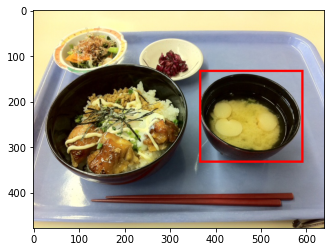

In [53]:
import random
from PIL import ImageDraw
from matplotlib.pyplot import imshow

fp = r"C:\Users\Marcus\Desktop\datasets\UECFOOD100"
transformer = torchvision.transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                             ])

food_label_dataset = UECFoodLabelsDataset(root=fp, transform=None)

# sample one randomly and show
i = random.randrange(0, len(food_label_dataset))
sample = food_label_dataset[i]

# trans = transforms.ToPILImage('RGB')
# img = trans(sample[0])
img = sample[0]
print("Label: ", sample[1])
draw = ImageDraw.Draw(img)
draw.rectangle(sample[2], outline="red", width=5)
imshow(np.asarray(img))